# Step 5b: Modeling

why LBM?


In [1]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

from src import preprocessing
from src import features
from src import config
from src import forecast

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Usage Instructions

This notebook uses the feature engineering module from `src/features.py`.

To run this notebook:
1. Ensure you have data in `data/landing/311-service-requests/`
2. Run `pip install -r requirements.txt` to install dependencies
3. Execute cells sequentially

For detailed documentation, see `src/FEATURE_ENGINEERING_README.md`


## Load Data

In [2]:
forecast_panel = pd.read_parquet(config.PRESENTATION_DATA_PATH + '/model_fitting_data.parquet')


## Fit Modesl

In [3]:
numerical_columns = config.NUMERICAL_COLUMNS

categorical_columns = config.CATEGORICAL_COLUMNS
horizons = [1]

### Fit Mean Models

In [4]:
bundle_mean = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    'mean'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-1.123009   -0.61228784 -0.64047328 -0.64401533 -0.67888112 -0.71974479
 -0.76196127 -0.76838343 -0.75668647 -0.75152926 -0.71633305 -0.8292906
 -0.8542578  -0.84027068]
CV mean: -0.7640802803655936
train metrics
  h=1: RMSE=1.158, MAE=0.726, Poisson Dev=1.100
test metrics
  h=1: RMSE=1.430, MAE=0.820, Poisson Dev=1.246



### Fit 90th Percentile Models

In [5]:
bundle_90 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '90'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-2.00198925 -1.2163005  -1.25628151 -1.28613771 -1.31201404 -1.36402884
 -1.44968184 -1.47474571 -1.46861974 -1.44863729 -1.39180572 -1.47139059
 -1.64971201 -1.66214605]
CV mean: -1.4609636284341292
train metrics
  h=1: RMSE=1.906, MAE=1.451, Poisson Dev=2.168
test metrics
  h=1: RMSE=2.182, MAE=1.576, Poisson Dev=2.322



### Fit 50th Percentile Models

In [6]:
bundle_50 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '50'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-0.64490466 -0.52415032 -0.55833863 -0.55788902 -0.60164152 -0.64738295
 -0.69472784 -0.69332472 -0.68222542 -0.67668758 -0.63037832 -0.76291226
 -0.76454014 -0.74983327]
CV mean: -0.6563526171611846
train metrics
  h=1: RMSE=1.247, MAE=0.647, Poisson Dev=6.848
test metrics
  h=1: RMSE=1.485, MAE=0.733, Poisson Dev=7.049



### Fit 10th Percentile Models

In [7]:
bundle_10 = forecast.train_models(
    forecast_panel,
    numerical_columns,
    categorical_columns,
    horizons,
    '10'
)

Training model for horizon 1
X shape pre-filtering: (547535, 29)
X shape post-filtering: (547535, 29)
Train dates [2009-12-29 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (487161, 29)
X test shape: (60374, 29)
CV (neg_mean_absolute_error) scores: [-0.64399041 -0.62409164 -0.68025089 -0.67049307 -0.74986589 -0.82538602
 -0.902516   -0.90493405 -0.87748215 -0.86193884 -0.76942477 -0.9929301
 -1.00359759 -0.97552166]
CV mean: -0.8201730765813852
train metrics
  h=1: RMSE=1.687, MAE=0.829, Poisson Dev=26.427
test metrics
  h=1: RMSE=2.033, MAE=0.931, Poisson Dev=27.258



### Save All Bundles

In [8]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# forecast.save_bundle(bundle_mean,  timestamp, 'lgb_mean.pkl')
# forecast.save_bundle(bundle_90,  timestamp, 'lgb_90.pkl')
# forecast.save_bundle(bundle_50,  timestamp, 'lgb_50.pkl')
# forecast.save_bundle(bundle_10,  timestamp, 'lgb_10.pkl')

## Evaluate Models

### Evaluate Mean Models

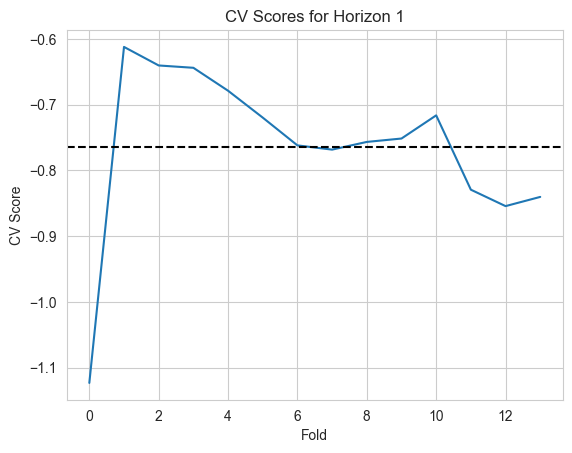

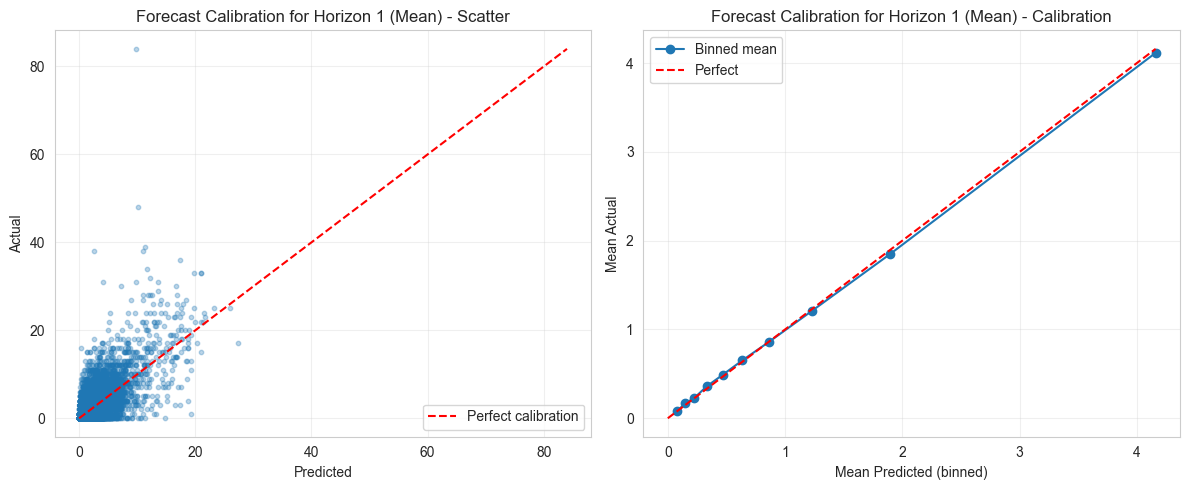

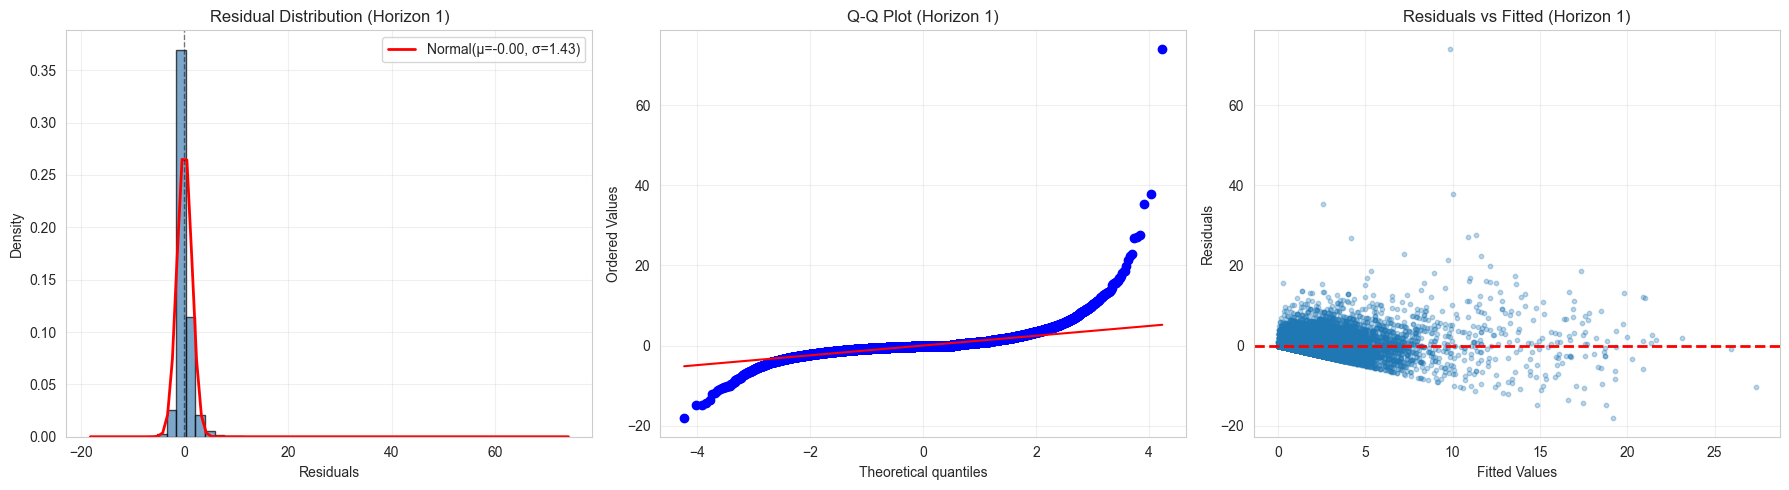


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -0.0024
  Std Dev: 1.4295
  Median: -0.1808
  Skewness: 5.0949
  Kurtosis: 159.7793

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8168
  P-value: 6.0387e-60
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 3527.1326
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.1584583863459479, 'mae': 0.7256516337822149, 'poisson_deviance': 1.099705866088741, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4295095422968525, 'mae': 0.8196896237827317, 'poisson_deviance': 1.2464631637502626, 'n_samples': 60374}}



In [9]:
reload(forecast)
forecast.evaluate_models(bundle_mean, model_type = 'mean')

### Evaluate 90th Percentile Models

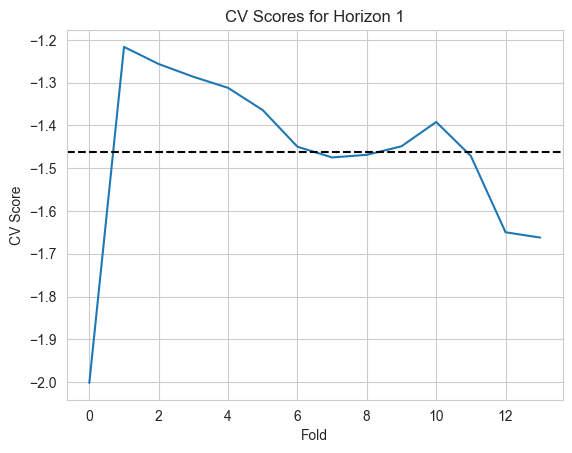

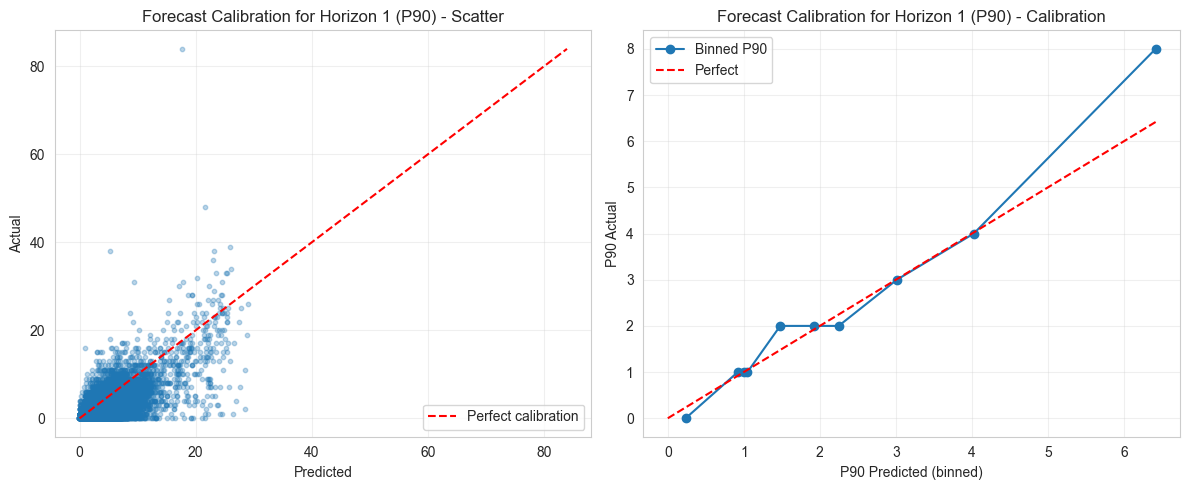

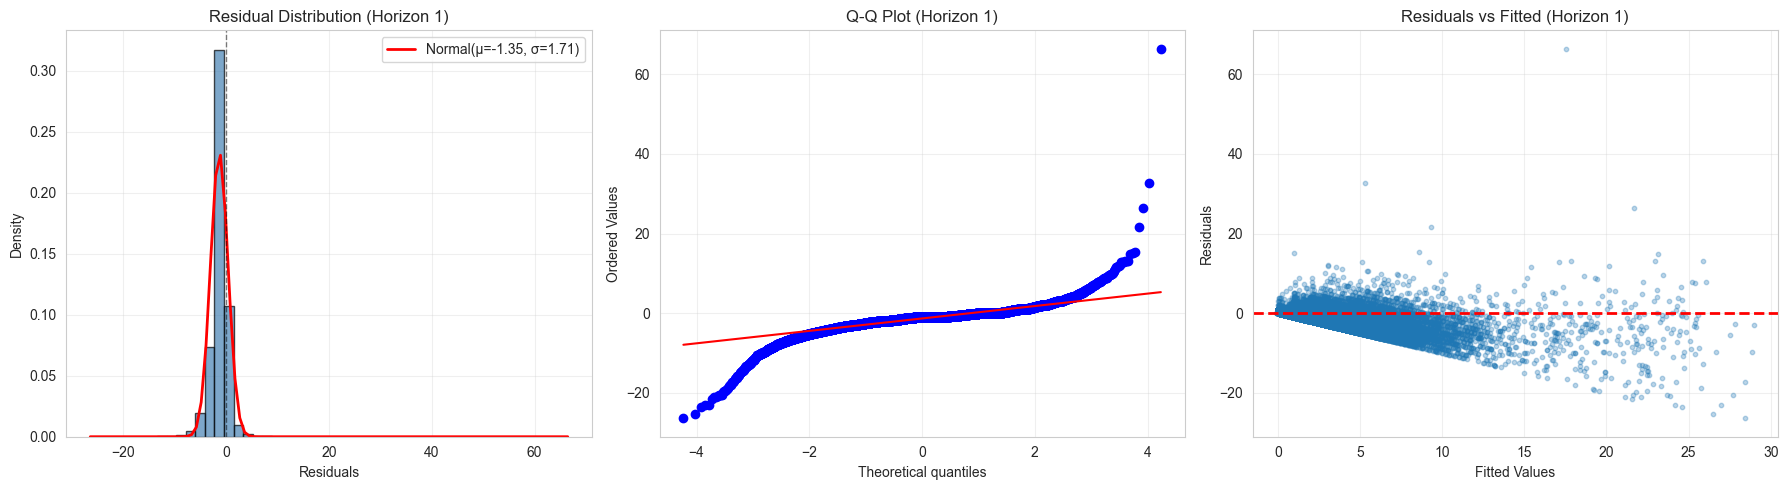


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -1.3518
  Std Dev: 1.7125
  Median: -1.0229
  Skewness: -0.0697
  Kurtosis: 59.0365

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8500
  P-value: 2.8322e-56
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1980.0488
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.9058719235745105, 'mae': 1.4513612379249703, 'poisson_deviance': 2.1675191776143388, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.1817414895651854, 'mae': 1.576305009424253, 'poisson_deviance': 2.3217836482125747, 'n_samples': 60374}}



In [10]:
reload(forecast)
forecast.evaluate_models(bundle_90, model_type = '90')

### Evaluate 50th Percentile Models

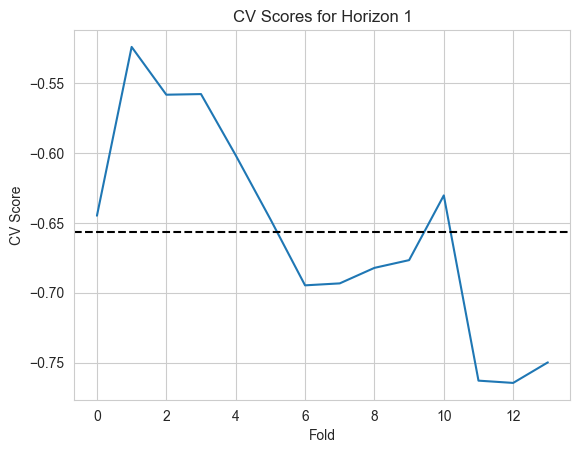

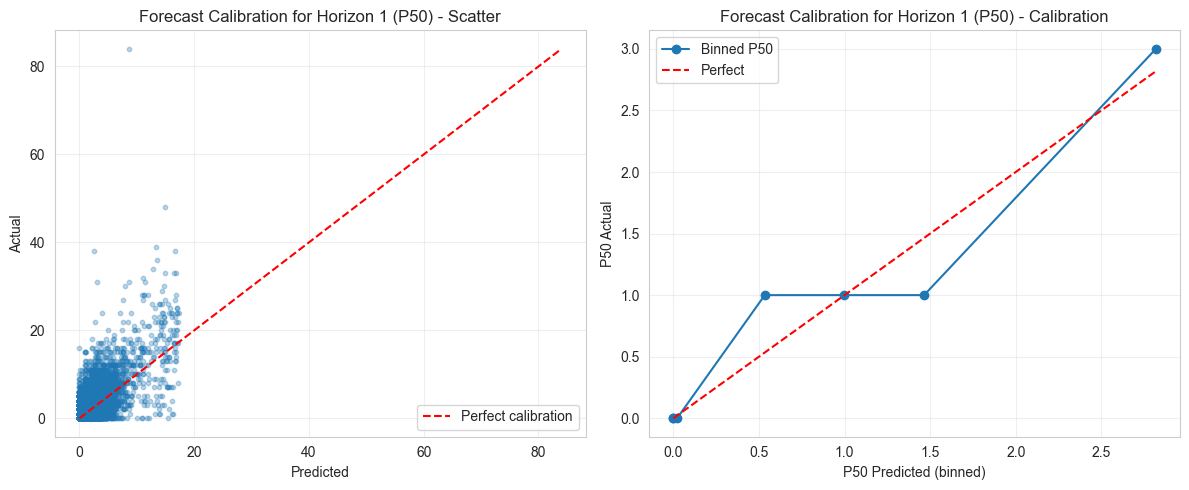

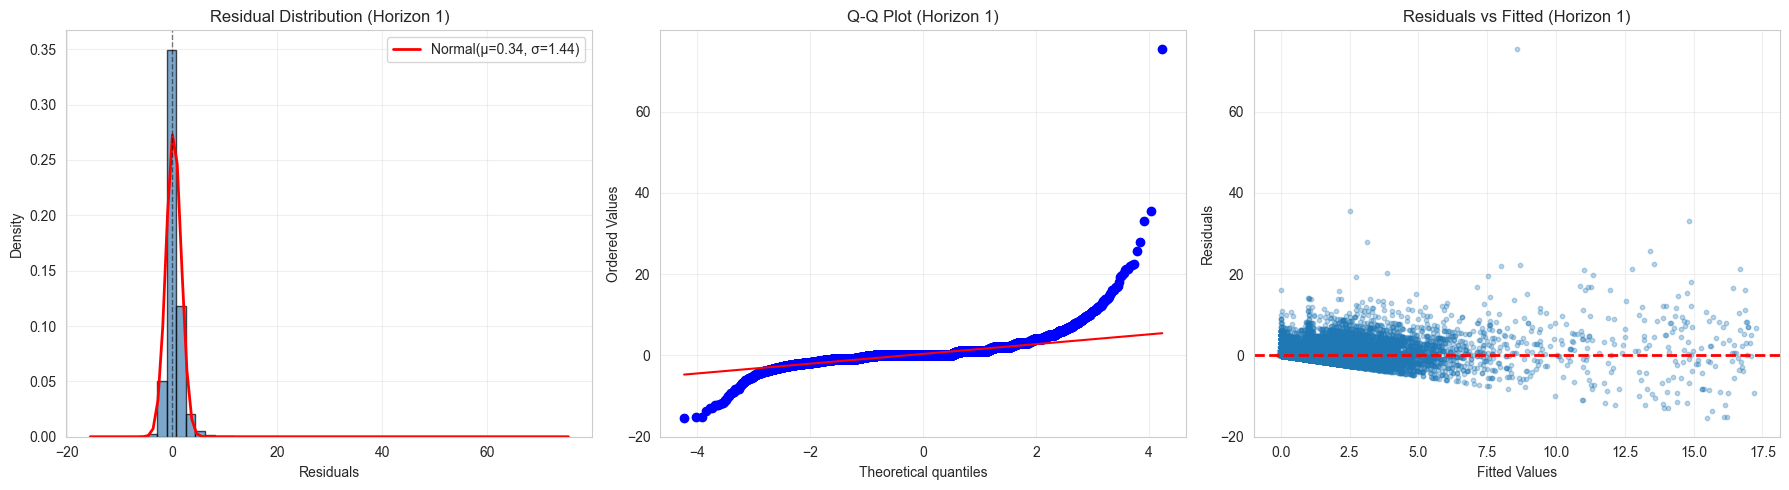


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.3416
  Std Dev: 1.4450
  Median: 0.0000
  Skewness: 5.1554
  Kurtosis: 155.6399

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.7202
  P-value: 4.2363e-68
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 5050.2626
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.246844313213766, 'mae': 0.6466420541725157, 'poisson_deviance': 6.847640219899114, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4848077641039132, 'mae': 0.7332055327644321, 'poisson_deviance': 7.048815525235706, 'n_samples': 60374}}



In [11]:
reload(forecast)
forecast.evaluate_models(bundle_50, model_type = '50')

### Evaluate 10th Percentile Models

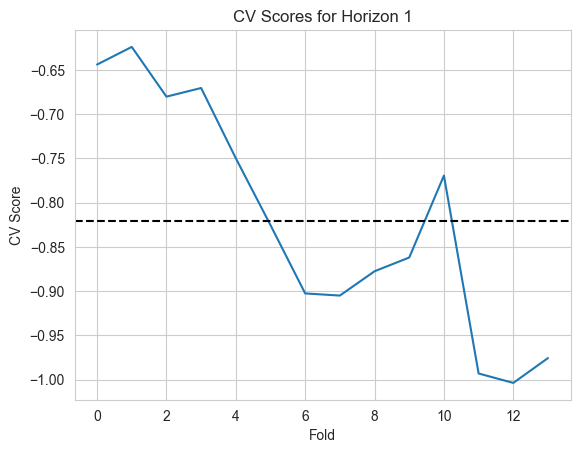

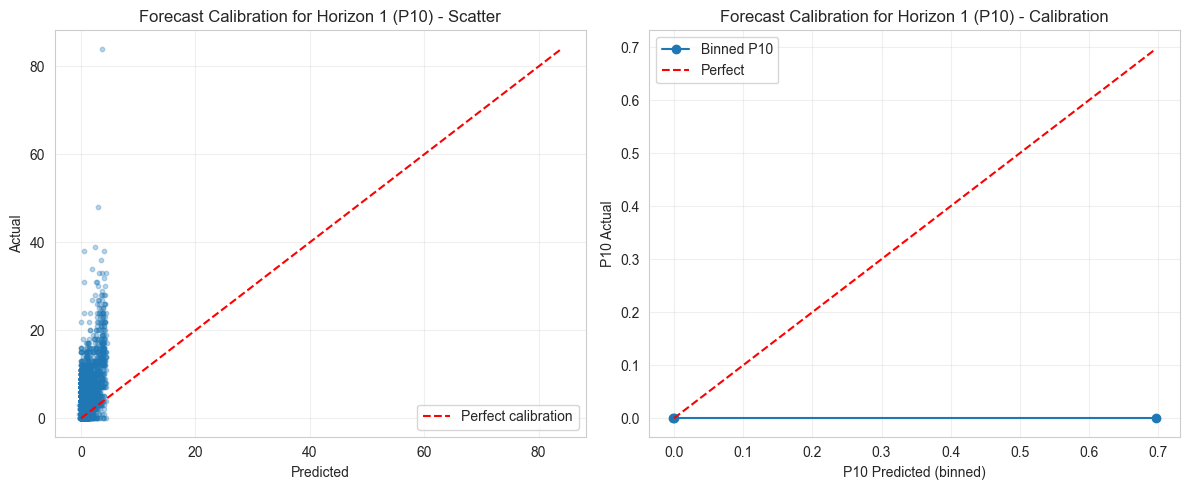

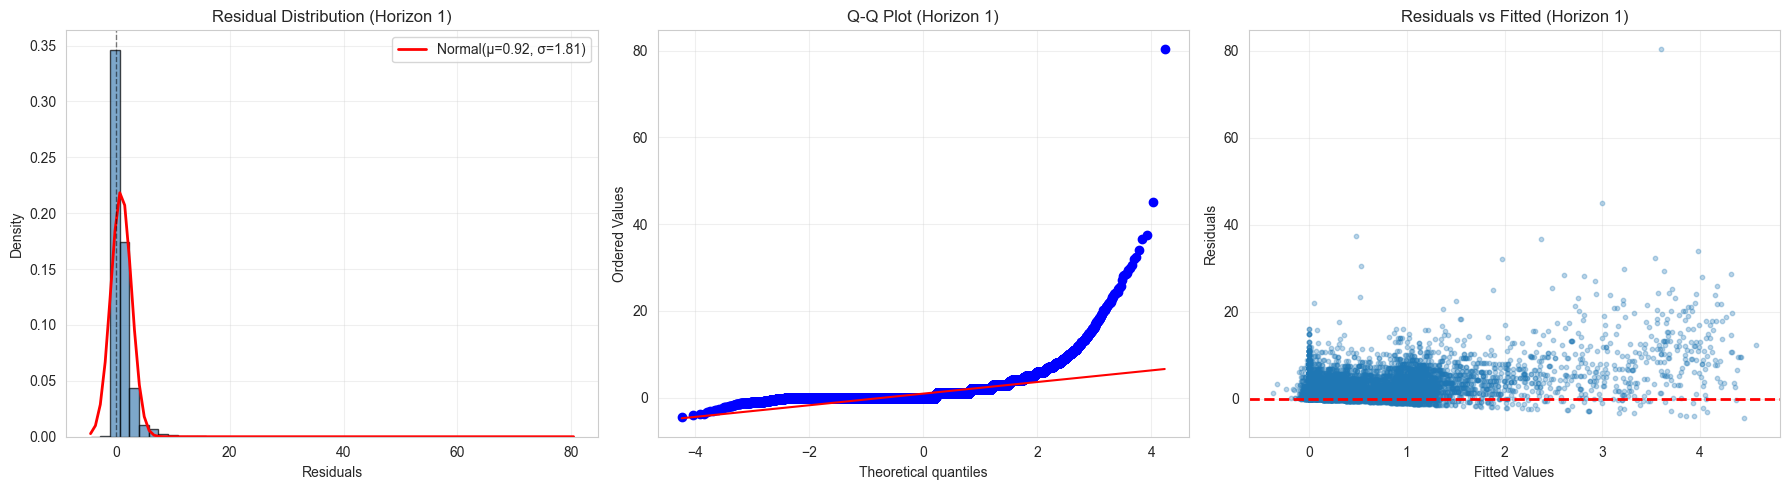


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.9182
  Std Dev: 1.8134
  Median: 0.0000
  Skewness: 6.1171
  Kurtosis: 107.2500

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.6046
  P-value: 3.7057e-75
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 7661.1556
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.6869617843384026, 'mae': 0.8285948709595505, 'poisson_deviance': 26.426714675319, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.0326410363805802, 'mae': 0.9307042391139765, 'poisson_deviance': 27.257695994960162, 'n_samples': 60374}}



In [12]:
reload(forecast)
forecast.evaluate_models(bundle_10, model_type = '10')